In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy

import matplotlib.pyplot as plt
%matplotlib inline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
review = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
review.shape

(568454, 10)

In [5]:
review.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [6]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [11]:
review.nunique()

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218415
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

We then need to focus features that are relevant for to classify the comment

In [13]:
text_review = review[["Text","Score"]]

In [14]:
text_review.isnull().sum()

Text     0
Score    0
dtype: int64

In [15]:
text_review.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [17]:
text_review.shape

(568454, 2)

For the sake of this task, I will be working with first 1000 dataset

In [19]:
text_review = text_review.iloc[:1000]

In [21]:
text_review.Score.value_counts()

Score
5    642
4    138
1     98
3     75
2     47
Name: count, dtype: int64

I want to classify the score as either good (>= 3) or bad (<3)


In [22]:
text_review.Score[text_review.Score<3] = 0
text_review.Score[text_review.Score>=3] = 1


/tmp/ipykernel_36/2815500964.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  text_review.Score[text_review.Score<3] = 0
/tmp/ipykernel_36/2815500964.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You ar

In [23]:
text_review.Score.value_counts()

Score
1    855
0    145
Name: count, dtype: int64

In [28]:
sample_text = text_review.Text[9]
sample_text

'This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.'

**Preprocessing**

In [36]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

stop_words = set(stopwords.words('english'))

def preprocess(text, lemmatize=False):
    """
    Preprocess a given text string by normalizing, tokenizing, 
    and optionally lemmatizing its words.

    Steps performed:
        1. Convert text to lowercase.
        2. Tokenize text into words.
        3. Remove punctuation and stopwords.
        4. Optionally lemmatize words.

    Args:
        text (str): The input text to be preprocessed.
        lemmatize (bool, optional): Whether to apply lemmatization 
            to tokens. Defaults to False.

    Returns:
        list: A list of processed tokens (strings) after 
        normalization, filtering, and optional lemmatization.
    """
    # lowercase
    text = text.lower()
    # rokenize
    tokens = word_tokenize(text)
    # emove punctuation and stopwords
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
text_review['tokens'] = text_review['Text'].apply(lambda x: preprocess(str(x), lemmatize=True))
text_review.head()

,Text,Score,tokens
0,I have bought several of the Vitality canned d...,1,"[bought, several, vitality, canned, dog, food,..."
1,Product arrived labeled as Jumbo Salted Peanut...,0,"[product, arrived, labeled, jumbo, salted, pea..."
2,This is a confection that has been around a fe...,1,"[confection, around, century, light, pillowy, ..."
3,If you are looking for the secret ingredient i...,0,"[looking, secret, ingredient, robitussin, beli..."
4,Great taffy at a great price. There was a wid...,1,"[great, taffy, great, price, wide, assortment,..."


**Exploratory Data Analysis******

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [43]:
#get length of each reviiew
text_review["length"] = text_review['tokens'].apply(len)

In [44]:
text_review["length"]

0      23
1      18
2      39
3      18
4      13
       ..
995    44
996    28
997    25
998    24
999    64
Name: length, Length: 1000, dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


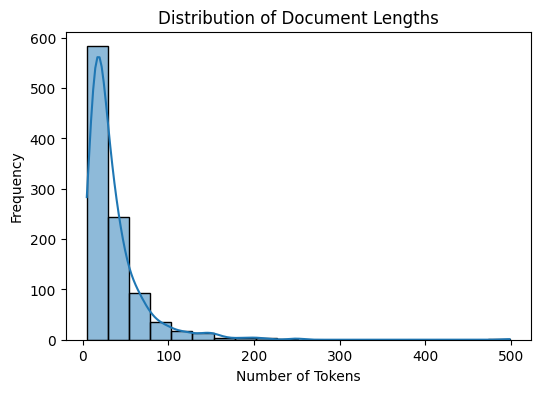

In [45]:
plt.figure(figsize=(6,4))
sns.histplot(text_review["length"], bins=20, kde=True)
plt.title("Distribution of Document Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

In [49]:
words = [word for token in text_review["tokens"] for word in token]
words[:10]

['bought',
 'several',
 'vitality',
 'canned',
 'dog',
 'food',
 'product',
 'found',
 'good',
 'quality']

In [50]:
word_counter = Counter(words)

In [55]:
top_10 = sorted(word_counter.items(), key=lambda x: x[1], reverse=True)[:10]
top_10

[('br', 1102),
 ('chip', 648),
 ('like', 433),
 ('flavor', 365),
 ('taste', 336),
 ('good', 323),
 ('bag', 313),
 ('one', 300),
 ('great', 283),
 ('food', 273)]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


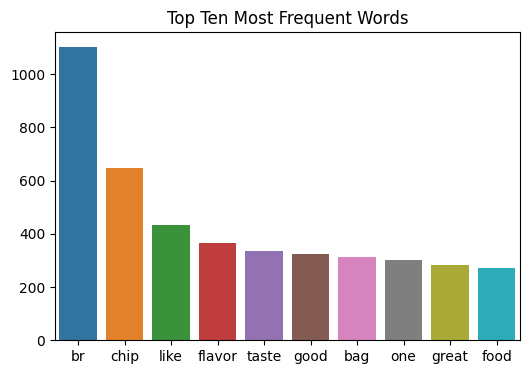

In [59]:
word, counts = zip(*top_10)
plt.figure(figsize=(6,4))
sns.barplot(x=list(word), y=list(counts))
plt.title("Top Ten Most Frequent Words")
plt.show()


**Data Extractions**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


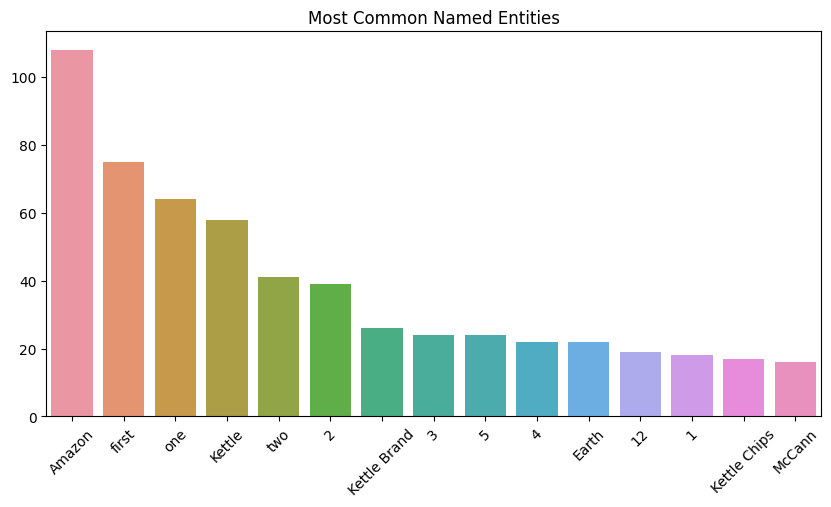

In [60]:
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    """
    Extract named entities from a given text using a spaCy NLP model.

    Args:
        text (str): The input text from which to extract entities.

    Returns:
        list: A list of strings, where each string is a named entity
        found in the text.
    """
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

text_review['entities'] = text_review['Text'].apply(lambda x: extract_entities(str(x)))
all_entities = [ent for ents in text_review['entities'] for ent in ents]
entity_freq = Counter(all_entities).most_common(15)

entity_names, entity_counts = zip(*entity_freq)
plt.figure(figsize=(10,5))
sns.barplot(x=list(entity_names), y=list(entity_counts))
plt.title("Most Common Named Entities")
plt.xticks(rotation=45)
plt.show()


Part 2

In [61]:
import re

def regex_extract(text):
    """
    Extract dates, prices, and numeric values from a given text using regular expressions.

    Args:
        text (str): The input text to search for matches.

    Returns:
        dict: A dictionary containing:
            - "dates" (list): Dates in formats like DD/MM/YYYY, DD-MM-YY, or YYYY-MM-DD.
            - "prices" (list): Prices with a leading dollar sign (e.g., "$12.50").
            - "numbers" (list): Integer or decimal numbers without currency symbols.

    """
    dates = re.findall(r'\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}-\d{2}-\d{2})\b', text)
    prices = re.findall(r'\$\d+(?:\.\d{1,2})?', text)
    numbers = re.findall(r'\b\d+(?:\.\d+)?\b', text)
    return {"dates": dates, "prices": prices, "numbers": numbers}


In [67]:
sample_text = text_review.Text[60]
sample_text

'Watch your prices with this.  While the assortment was good, and I did get this on a gold box purchase, the price for this was<br />$3-4 less at Target.'

In [68]:
regex_extract(sample_text)

{'dates': [], 'prices': ['$3'], 'numbers': ['3', '4']}

In [69]:
def spacy_ner(text):
    """
    Perform Named Entity Recognition (NER) on a given text using a spaCy NLP model.

    Args:
        text (str): The input text to analyze.

    Returns:
        list: A list of tuples, where each tuple contains:
            - ent.text (str): The exact entity string from the text.
            - ent.label_ (str): The entity type label (e.g., PERSON, ORG, DATE).
    """
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

In [71]:
spacy_ner(sample_text)

[('Target', 'ORG')]

**Data Summarization**

In [74]:
!pip install sumy

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.5 MB/s eta 0:00:00:00:0100:01
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=3c46ab454d67c3cec321a3489ecf236547d31707c6f057cdf892d868e47f1c86
  Stored in directory: /root/.cache/pip/wheels/4d/57/58/7e3d7fedf51fe248b7fcee3df6945ae28638e22cddf01eb92b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=9b9d57a268d0860e881057f86656f15090cc7fcac2c0877fc0ca14bb21287761
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built breadability docopt


In [76]:
def textrank_sumy(text, sentence_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentence_count)
    return " ".join(str(sentence) for sentence in summary)

In [82]:
text = text_review.Text[10]
text

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

In [85]:

print(textrank_sumy(text,1))

When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.


In [89]:
!pip install transformers sentencepiece

from transformers import pipeline

summarizer = pipeline("summarization", model="t5-small", tokenizer="t5-small")


2025-08-10 12:27:20.737379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754828840.983472      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754828841.052840      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


In [91]:
print("Abstractive Summary:")
print(summarizer(text, max_length=30, min_length=5, do_sample=False)[0]['summary_text'])


Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Abstractive Summary:
the camera quality is excellent, with crisp and vibrant colors . battery life is decent but could be better for long trips.


In [87]:
!pip install rouge-score
from rouge_score import rouge_scorer

In [88]:

ref = "The camera is great but battery life is short."
gen = "The camera quality is excellent but battery is average."

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
print(scorer.score(ref, gen))


{'rouge1': Score(precision=0.6666666666666666, recall=0.6666666666666666, fmeasure=0.6666666666666666), 'rougeL': Score(precision=0.6666666666666666, recall=0.6666666666666666, fmeasure=0.6666666666666666)}
